### Traffic Simulation

In [679]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import scipy as sp
import pandas as pd
import time


class TrafficSimulation:

    def __init__(self, size=50, car_density=0.1 ,vmax=5, p_slow = 0):
        self.car_density = car_density
        self.size = size
        self.state = np.zeros(size,dtype=np.int64)
        self.p_slow = p_slow

    def initialize(self):

        self.state.fill(-1)

        # Place random trees with the requested density
        random_indexes = sp.random.choice(
            range(self.size),
            size=int(round(self.car_density * self.size)),
            replace=False)
        self.state.flat[random_indexes] = 1

        # Ignite one random tree
        if len(random_indexes) > 0:
            self.state.flat[random_indexes[0]] = 3

        self.time_step = 0
        self.changed = True  # Track whether the state changed between the
                             # previous time step and the current one

    def draw(self):
        fig, bars = plt.subplots(1, figsize=(15,7))
        bars.cla()
        bars.pcolor(sim.state.reshape(1,sim.state.shape[0]),vmin = -1, vmax = 5, cmap = plt.cm.binary)
        bars.axis('image')
        bars.set_xticks(range(0,sim.state.shape[0]+1,2))
        bars.set_title('t = ' + str(self.time_step)) 
        if self.time_step == 0:
            cbaxes = fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(bars.pcolor(sim.state.reshape(1,sim.state.shape[0]),vmin = -1, vmax = 5, cmap = plt.cm.binary)
            , cax = cbaxes, orientation = 'horizontal')  

        fig.subplots_adjust(left=0)
        fig.show()    
            
    def update(self):
        self.time_step += 1

        next_state = -1*np.ones(self.state.shape,dtype=np.int64)
        #post_state = np.zeros(20,dtype=np.int64)
        # Empty cells stay empty
        
        cars = np.where(self.state >= 0)[0]
        #print 'cars: '+str(cars)
        next_car = [cars[(i+1)%len(cars)] for i in range(len(cars))]
        #print 'next cars: '+str(next_car) 
                
        def car_distance(x,y):
            if x > y: return x - y
            else: return self.state.shape - x + y

        for i,car in enumerate(cars):
            if self.state[car] < vmax and car_distance(next_car[i], car) > self.state[car]+1:
                self.state[car] += 1
            elif car_distance(next_car[i], car) <= self.state[car] - 1:
                self.state[car] = car_distance(next_car[i], car) - 1
        
        if np.random.random() < self.p_slow:
            for i in cars:
                self.state[i] -=1
        
        for x in cars[np.where(cars > 0)]: #only slow down cars that are actually running
            next_state[(x + self.state[x])%sim.state.shape[0]] = self.state[x]

        self.state = next_state

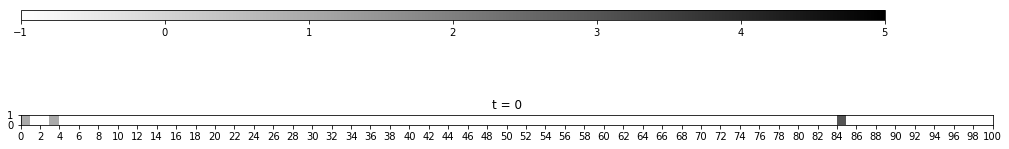

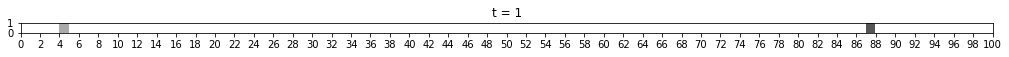

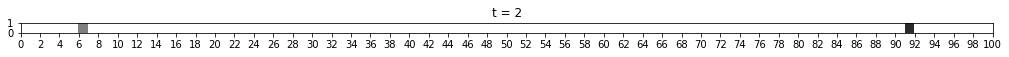

In [680]:
sim = TrafficSimulation(size=100,car_density=0.03, p_slow = 0.2)
sim.initialize()
sim.draw()

for t in range(2):
    sim.update()
    sim.draw()
#print(pd.DataFrame((sim.state.reshape(-1,len(sim.state)))))

In [474]:
mock_state = np.array([0, 1, 0, 0 , 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,0])

In [475]:
vmax = 5
cars = np.where(mock_state > 0)[0]
print 'cars: '+str(cars)
next_car = [cars[(i+1)%len(cars)] for i in range(len(cars))]
print 'next cars: '+str(next_car) 
post_state = np.zeros(20,dtype=np.int64)

def car_distance(x,y):
    if x > y: return x-y
    else: return len(mock_state) - x + y

for i,car in enumerate(cars):
    if mock_state[car] < vmax and car_distance(next_car[i], car) > mock_state[car]+1:
        mock_state[car] += 1
    elif car_distance(next_car[i], car) <= mock_state[car] - 1:
        mock_state[car] = car_distance(next_car[i], car) - 1
    
    print(mock_state)
    
    for x in cars:
        post_state[(x + mock_state[x])%len(mock_state)] = mock_state[x]
    
    print('\033[94m' + str(post_state)+ '\x1b[0m')
    
mock_state = post_state
print mock_state

cars: [ 1  5  8 11 14 18]
next cars: [5, 8, 11, 14, 18, 1]
[0 2 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0]
[0 0 0 2 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1]
[0 2 0 0 0 2 0 0 1 0 0 1 0 0 1 0 0 0 1 0]
[0 0 0 2 0 0 1 2 0 1 0 0 1 0 0 1 0 0 0 1]
[0 2 0 0 0 2 0 0 2 0 0 1 0 0 1 0 0 0 1 0]
[0 0 0 2 0 0 1 2 0 1 2 0 1 0 0 1 0 0 0 1]
[0 2 0 0 0 2 0 0 2 0 0 2 0 0 1 0 0 0 1 0]
[0 0 0 2 0 0 1 2 0 1 2 0 1 2 0 1 0 0 0 1]
[0 2 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 1 0]
[0 0 0 2 0 0 1 2 0 1 2 0 1 2 0 1 2 0 0 1]
[0 2 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 2 0]
[2 0 0 2 0 0 1 2 0 1 2 0 1 2 0 1 2 0 0 1]
[2 0 0 2 0 0 1 2 0 1 2 0 1 2 0 1 2 0 0 1]
